Gerekli Kütüphaneler yükleniyor

In [37]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

Kaggle Veri setinin indirilmesi ve dosya yolunun yazdırılması

In [35]:
import kagglehub

path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


Data augmentation (Veri Arttırımı) işlemlerinin uygulanması

In [38]:
output_dir ='/kaggle/working/augmented_images'
os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
data_dir = '/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data'
output_count = 2
label_names=["with_mask","without_mask"]

for class_name in label_names:
    output_dir =f'/kaggle/working/augmented_images/{class_name}'
    os.makedirs(output_dir, exist_ok=True)

    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)

    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)


        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=class_name, save_format='jpeg'):
            i +=1
            if i >= output_count:
                break

Maskeli veri setinin dosya tanımlaması

In [39]:
with_mask_data = os.listdir(r'/kaggle/working/augmented_images/with_mask')

Örnek 5 tanesinin getirilmesi

In [40]:
print(with_mask_data[0:5])

['with_mask_0_1035.jpeg', 'with_mask_0_9698.jpeg', 'with_mask_0_4774.jpeg', 'with_mask_0_3961.jpeg', 'with_mask_0_3746.jpeg']


Veri Arttırımı sonrası oluşan Maskeli veri sayısı

In [41]:
print('Number of with mask images:', len(with_mask_data))

Number of with mask images: 5211


Maskesiz veri setinin dosya tanımlamasının yapılması

In [42]:
without_mask_data = os.listdir(r'/kaggle/working/augmented_images/without_mask')

Örnek 5 tanesinin getirilmesi

In [43]:
print(without_mask_data[0:5])

['without_mask_0_3247.jpeg', 'without_mask_0_9556.jpeg', 'without_mask_0_3278.jpeg', 'without_mask_0_2051.jpeg', 'without_mask_0_5481.jpeg']


Maskesiz veri sayısı

In [44]:
print('Number of without mask images:', len(without_mask_data))

Number of without mask images: 5342


Etiketleme işleminin yapılması

In [45]:
with_mask_labels = [1]*len(with_mask_data)
print(f"With Mask labels" ,with_mask_labels[0:10])

without_mask_labels = [0]*len(without_mask_data)
print(f"Without Mask Labels", without_mask_labels[0:10])

With Mask labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Without Mask Labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Maskeli ve Maskesiz etiketlerin birleştirilmesi

In [46]:
Labels = with_mask_labels + without_mask_labels
print(f"Labels", Labels[0:10])
print(f"Labels", Labels[-10:])

Labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Örnek bir maskeli resmin rastgele gösterimi

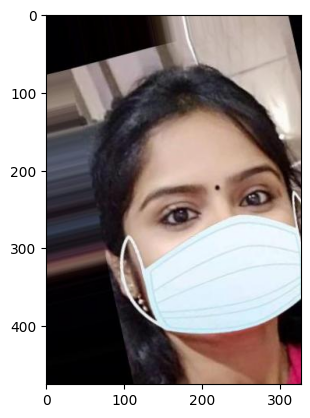

In [48]:
import random
random_image = random.choice(with_mask_data)
img = Image.open('/kaggle/working/augmented_images/with_mask' + '/' + random_image)
plt.imshow(img)

Örnek bir maskesiz resmin rastgele gösterimi

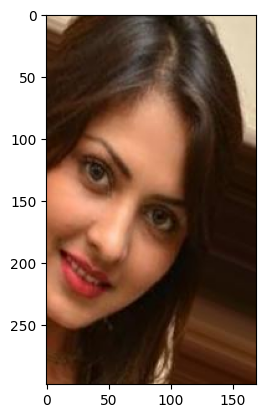

In [49]:
import random
random_image = random.choice(without_mask_data)
img = Image.open(r'/kaggle/working/augmented_images/without_mask' + '/' + random_image)
plt.imshow(img)

Resim dosyalarının yeniden boyutlandırılması

In [51]:
images = []
def load_images_from_folder(folder):

    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        img = img.resize((128,128))
        img = img.convert('RGB')
        images.append(np.array(img))
    return images

with_mask_images = load_images_from_folder(r'/kaggle/working/augmented_images/with_mask')
without_mask_images = load_images_from_folder(r'/kaggle/working/augmented_images/without_mask')

Liste halindeki resim ve etiket lerin numpy array e çevrilmesi

In [58]:
X = np.array(images)
Y = np.array(Labels)

Veri setinin test ve eğitim olarak ayrılması

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Ayrılan veri setinin sayısal gösterimi

In [65]:
print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of Y_train is: {Y_train.shape}\n")
print(f"Shape of X_test is: {X_test.shape}")
print(f"Shape of Y_test is: {Y_test.shape}")

Shape of X_train is: (8442, 128, 128, 3)
Shape of Y_train is: (8442,)

Shape of X_test is: (2111, 128, 128, 3)
Shape of Y_test is: (2111,)


Veri setinin 0-1 arası ölçeklendirilmesi yapılıyor

In [66]:
X_train = X_train/255
X_test = X_test/255

Densenet121 Modelinin yapılandırılması yapılıyor

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# DenseNet121 modeli
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Modeli oluştur
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model Derleniyor (learning rate = 0.001)

In [68]:
model.compile(Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model özeti

In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 7,093,442 (27.06 MB)

 Non-trainable params: 83,648 (326.75 KB)

Model Eğitimi
Erken durdurma sayısı 25 olarak girildi
Validasyon kaybının iyileşme göstermemesi durumuna karşılık değerler tanımlandı

In [71]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

history = model.fit(X_train, Y_train, epochs=100, callbacks=[early_stop, reduce_lr], validation_split=0.1)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9890 - loss: 0.0384 - val_accuracy: 0.9243 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9918 - loss: 0.0262 - val_accuracy: 0.9704 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9871 - loss: 0.0361 - val_accuracy: 0.9846 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9955 - loss: 0.0146 - val_accuracy: 0.9775 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9944 - loss: 0.0181 - val_accuracy: 0.9148 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9879 - loss: 0.0384 - val_accuracy: 0.9858 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9

Test Doğruluğu yazdırılıyor

In [73]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy =', accuracy)

66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.9941 - loss: 0.0177
Test Accuracy = 0.9933680891990662


Sınıflandırma değerleri yazdırılıyor

In [74]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(Y_test, y_pred))

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1051
           1       0.99      0.99      0.99      1060

    accuracy                           0.99      2111
   macro avg       0.99      0.99      0.99      2111
weighted avg       0.99      0.99      0.99      2111



Çalışan epoklara göre Kayıp ve Doğruluk eğrileri çizdiriliyor

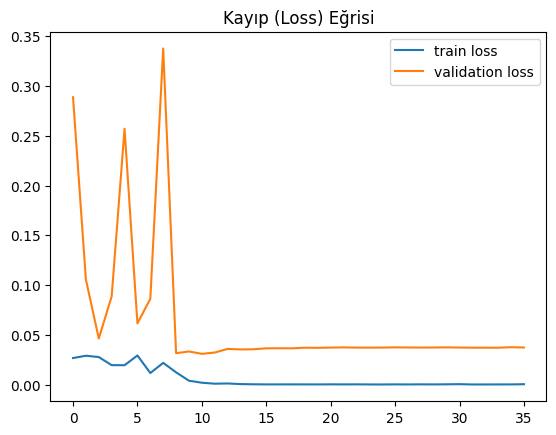

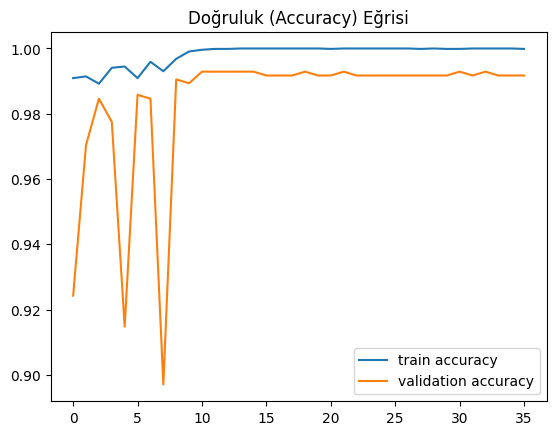

In [93]:
h = history

# Kayıp Değerleri için
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.title('Kayıp (Loss) Eğrisi')
plt.legend()
plt.show()

# Doğruluk Değerleri için
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.title('Doğruluk (Accuracy) Eğrisi')
plt.legend()
plt.show()

Karışıklık Matrisi (Confusion Matrix) Grafiği çizdiriliyor

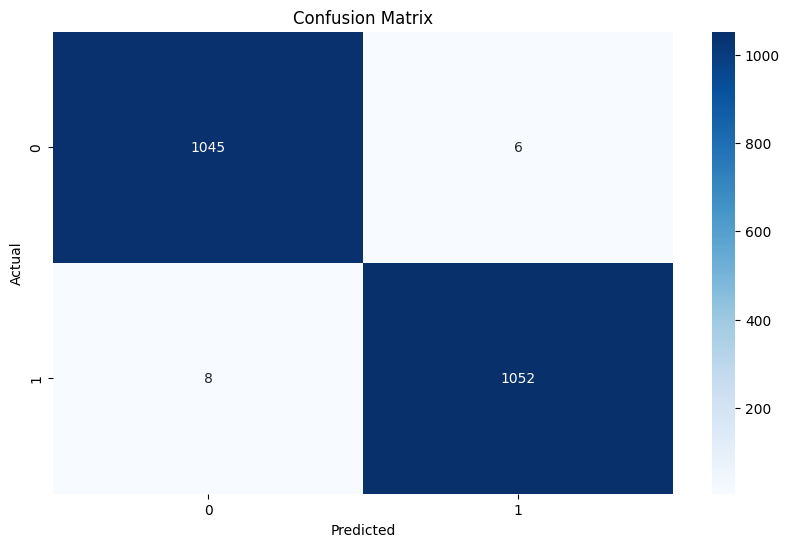

In [76]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ROC Eğrisi çizdiriliyor

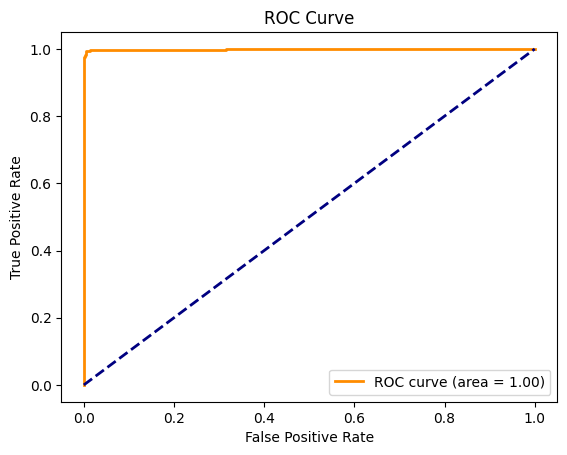

In [92]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Örnek bir Maskesiz image dosyası üzerinden model test ediliyor

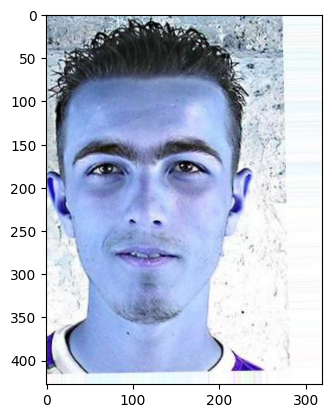

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[9.999014e-01 9.854889e-05]]
0
The person in the image is not wearing a mask


In [78]:
input_image_path = '/kaggle/working/augmented_images/without_mask/without_mask_0_1012.jpeg'

input_image = cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

Örnek bir Maskeli image dosyası üzerinden model test ediliyor

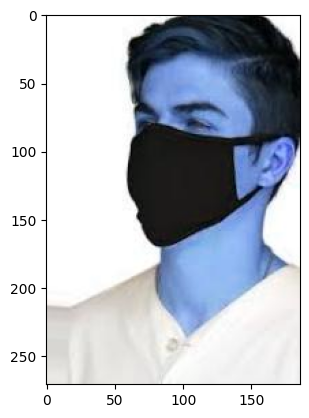

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1.05517676e-04 9.99894500e-01]]
1
The person in the image is wearing a mask


In [81]:
input_image_path = '/kaggle/working/augmented_images/with_mask/with_mask_0_1010.jpeg'

input_image = cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

# SONUÇ :
Genel bir değerlendirme yapacak olursak
ROC Curve, Confusion Matrix ve diğer metrik sonuçlarına bakacak olursak model başarısı çok yüksek görünüyor.
100 Epoch olarak başlatılan modelin 36 da sonlanması da buna işaret ediyor.
Validation Loss değeri bir noktadan sonra sabit ve yukarı yönlü olmadığı için aşırı öğrenme (overftting) durumu yok gibi görünüyor.
# Daha detaylı inceleme için aşağıdaki adımlar denenebilir;
*   Öğrenme değeri düşürülebilir,
*   Patience değeri arttırılabilir